In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [3]:
import json
import urllib.request

# Load ImageNet class labels from PyTorch's GitHub
url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
labels = []
with urllib.request.urlopen(url) as f:
    labels = [line.decode('utf-8').strip() for line in f.readlines()]

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Define transform (ImageNet-style)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ImageFolder("/content/drive/MyDrive/ImageNetSamples", transform=transform)


Mounted at /content/drive


In [14]:
import random
# Pick random image from dataset
img_tensor, label = random.choice(dataset)

# Prepare input for model
input_img = img_tensor.unsqueeze(0)  # Add batch dimension


(-0.5, 223.5, 223.5, -0.5)

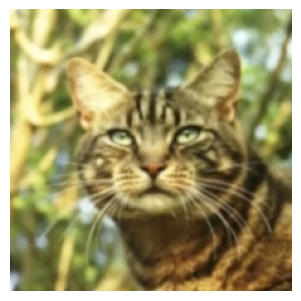

In [15]:
img_np = input_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
img_np = np.clip(img_np, 0, 1)
original_img = img_np
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
# plt.title("Original Image")
plt.axis('off')

In [16]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [17]:
import torch.nn.functional as F

# Run inference
output = model(input_img)
output = F.softmax(output, dim=1)

# Get top prediction
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx = pred_label_idx.item()
prediction_score = prediction_score.item()

# Use the labels list
predicted_label = labels[pred_label_idx]
print('Predicted:', predicted_label, '(', prediction_score, ')')


Predicted: tabby ( 0.7334997653961182 )


In [18]:
from captum.attr import GuidedBackprop, GuidedGradCam

# --- Grad-CAM setup (last conv layer) ---
target_layer = model.layer4[1].conv2
layer_gc = LayerGradCam(model, target_layer)
guided_gc = GuidedGradCam(model, target_layer)
guided_gc_attr = guided_gc.attribute(input_img, target=pred_label_idx)

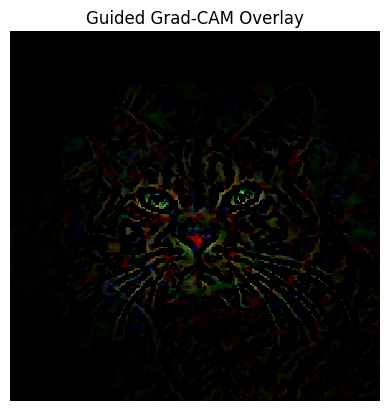

In [19]:
# Convert to image
guided_gc_np = guided_gc_attr.squeeze().permute(1, 2, 0).cpu().detach().numpy()
# guided_gc_np = np.maximum(guided_gc_np, 0)
# guided_gc_np = guided_gc_np / guided_gc_np.max()
guided_gc_np = guided_gc_np / guided_gc_np.max()
guided_gc_np = np.power(guided_gc_np, 0.5)  # Brighten

plt.imshow(guided_gc_np)
plt.axis('off')
plt.title("Guided Grad-CAM Overlay")
plt.show()